In [1]:
using CausalityTools, UncertainData, DynamicalSystems, Plots, StatsPlots

# Tutorial: `BinnedDataCausalityTest`

## `PredictiveAsymmetryTest` with `BinnedResampling`.

In [187]:
#?ar1_unidir

To simulate some measurement uncertainties, we'll use `example_uncertain_indexvalue_datasets` from [UncertainData.jl](https://github.com/kahaaga/UncertainData.jl/).

In [2]:
sys = ar1_unidir(uᵢ = [0.1, 0.1], c_xy = 0.41)
vars = (1, 2) # ar1_unidir has only two variables, X and Y
n_steps = 100
tstep = 10 # the mean of each time value is stepped by `tstep`

X, Y = example_uncertain_indexvalue_datasets(sys, n_steps, vars, tstep = 10, 
    d_xind = Uniform(7.5, 15.5), d_yind = Uniform(5.5, 15.5), d_xval = Uniform(0.1, 0.5));

Now we have a time series with normally distributed time indices with means 
ranging from 1 to 1001 in steps of 10. Let's say we want to bin the data 
with equally-sized bins with size 25.

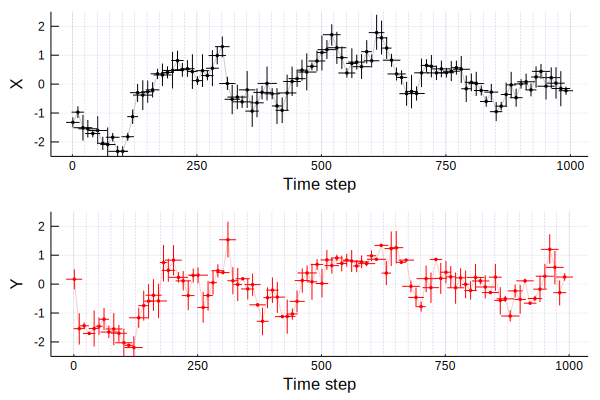

In [189]:
qs = [0.1, 0.9]

pX = plot(X, mc = :black, ms = 2, lw = 0.5, marker = stroke(0.0, :black), qs, qs, ylabel = "X")
plot!(pX, mean.(X.indices), mean.(X.values), c = :black, lw = 1, α = 0.2, label = "")
vline!(0:25:1000, ls = :dash, α = 0.5, lw = 0.5)
pY = plot(Y, mc = :red, ms = 2, lw = 0.5, marker = stroke(0.0, :red), qs, qs, ylabel = "Y")
plot!(pY, mean.(Y.indices), mean.(Y.values), c = :red, lw = 1, α = 0.2, label = "")
vline!(0:25:1000, ls = :dash, α = 0.5, lw = 0.5)
plot(pX, pY, layout = (2, 1), xlabel = "Time step", ylims = (-2.5, 2.5), legend = false)

## How do the data look when binned?

Let's use a slightly finer binning and investigate what the binned data look like.

The time uncertainty in each bin is assumed uniform, while the value uncertainty 
is represented as a kernel density estimate to the distribution of points in each bin.


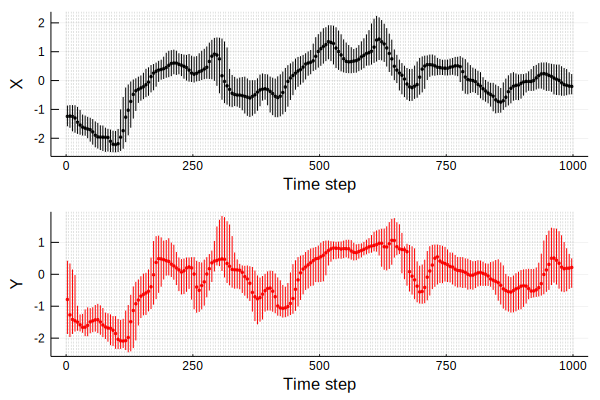

In [190]:
grid = 0:5:1000
n_draws = 5000 # resample each point 5000 times and distribute among bins
binned_resampling = BinnedResampling(grid, n_draws)

X_binned = resample(X, binned_resampling)
Y_binned = resample(Y, binned_resampling)

pX = plot(X_binned, qs, qs, ylabel = "X",
    mc = :black, ms = 2, lw = 0.5, marker = stroke(0.0, :black))
vline!(binned_resampling.left_bin_edges, ls = :dash, α = 0.5, lw = 0.5)

pY = plot(Y_binned, qs, qs, ylabel = "Y",
    mc = :red, ms = 2, lw = 0.5, marker = stroke(0.0, :red))
vline!(binned_resampling.left_bin_edges, ls = :dash, α = 0.5, lw = 0.5)

plot(pX, pY, layout = (2, 1), xlabel = "Time step", legend = false)

## Defining a PredictiveAsymmetryTest

A `PredictiveAsymmetryTest` takes as input a causality test that uses lagged 
prediction. Here, we'll use a transfer entropy test, using a visitation 
frequency estimator to perform the computations . We'll predict 5 time steps 
forwards and backwards in time (`ηs = -5:5`).

Transfer entropy is computing over a discretization of a state space 
reconstruction of the time series involves. Here, we'll use a 
3-dimensional reconstruction for the transfer entropy computations.

To do this computation, we need to specify how to discretize the reconstructed 
state space. To keeo it simple, we'll divide the state-space into hyperrectangular 
regions defined by diving each coordinate axis of the state space into equally-spaced 
intervals. We'll determine the number of intervals to split each axis into by a 
trade-off between the dimensionality of the system (ensuring enough points in each bin
on average) and the number of points in the system. The approach below 
roughly follows Krakovska et al. (2018).

In [191]:
k, l, m = 1, 1, 1 # embedding parameters, total dimension is k + l + m
n_subdivisions = floor(Int, length(grid)^(1/(k + l + m + 1)))
state_space_binning = RectangularBinning(n_subdivisions);

# Configure a visitation frequency estimator transfer entropy test
# using base-2 logarithms
ηs = -5:5 # we're predicting five steps forwards and backwards in time
te_test = VisitationFrequencyTest(k = k, l = l, m = m,
    binning = state_space_binning, b = 2, ηs = ηs)

pa_test = PredictiveAsymmetryTest(predictive_test = te_test)

# Now we can combine the binning from above with the predictive asymmetry 
# test we just defined. We'll apply the causality test to 50 independent 
# draws of the binned dataset.
n_realizations = 50
test = BinnedDataCausalityTest(pa_test, binned_resampling, n_realizations);

Finally, we can compute the predictive asymmetry in both directions.


In [192]:
tes_xy = causality(X, Y, test)
tes_yx = causality(Y, X, test);

`tes_xy` and `tes_yx` are now both length-`50` vectors, where each element is a length-`5` vector containing the predictive asymmetries for prediction lags `1:5`. Let's summarise the data for each prediction lag and plot the results.

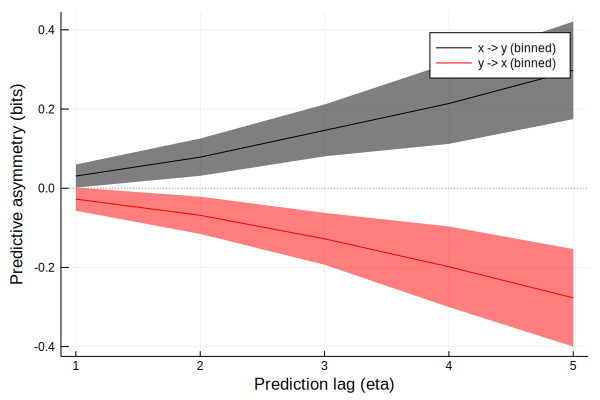

In [193]:
# Gather results in a matrix and compute means and standard deviations 
# for the predictive asymmetries at each prediction lag
M_xy = hcat(tes_xy...,)
M_yx = hcat(tes_yx...,)

means_xy = mean(M_xy, dims = 2)[:, 1]
means_yx = mean(M_yx, dims = 2)[:, 1]
stdevs_xy = std(M_yx, dims = 2)[:, 1]
stdevs_yx = std(M_yx, dims = 2)[:, 1]

# Plot the predictive asymmetry as a function of prediction lag
plot(xlabel = "Prediction lag (eta)", ylabel = "Predictive asymmetry (bits)")
plot!(ηs[ηs .> 0], means_xy, ribbon = stdevs_xy, label = "x -> y (binned)", c = :black)
plot!(ηs[ηs .> 0], means_yx, ribbon = stdevs_yx, label = "y -> x (binned)", c = :red)
hline!([0], lw = 2, ls = :dot, α = 0.5, label = "", c = :grey)